In [1]:
import os
from analyse.corner_plots import *
import corner
from analyse.read_posterior import *
from kinematics_halo import data
from pathlib import Path
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial.transform import Rotation as R
from matplotlib.ticker import MultipleLocator
plt.rcParams['figure.facecolor'] = 'white'

import matplotlib.cm as cm

In [2]:
os.getcwd()


'/mnt/c/Users/Rashid/Dropbox/Uni (r.yaaqib@gmail.com)/ubuntu_files/PhD/LMCMW/MWReflex/paper'

In [3]:
def create_name_strings(mock,btype="f",sclip=False):
    
    if btype == "sgr_20_4bin":
        if mock == "KG":
            parent = "chains_paper/binned_sgr_4bin/KG/"
            n = 4
        elif mock == "BHB":
            parent = "chains_paper/binned_sgr_4bin/BHB/"
            n = 4
        elif mock == "combined":
            n = 4
            parent = "chains_paper/binned_sgr_4bin/comb/"

    elif btype == "sgr_20_ol5":
        if mock == "KG":
            parent = "chains_paper/binned_sgr_20_ol5/KG/"
            n = 5
        elif mock == "BHB":
            parent = "chains_paper/binned_sgr_20_ol5/BHB/"
            n = 4
        elif mock == "combined":
            n = 5
            parent = "chains_paper/binned_sgr_20_ol5/comb/"
    elif btype == "s14":
        if mock == "binned":
            parent = "chains_paper/s14/binned_20/"
            n = 5
        elif mock == "north":
            parent = "chains_paper/s14/binned_20_north/"
            n = 5
        elif mock == "sdss":
            n = 5
            parent = "chains_paper/s14/binned_20_sdss/"
        elif mock == "allsky":
            n = 5
            parent = "chains_paper/s14/binned_20_allsky/"

    elif btype == "s14_old":
        pre = "/mnt/d/Paper1/"
        if mock == "sdss_old":
            parent = pre + "chains/binned_mocks/s14/"
            n = 7
        elif mock == "allsky":
            parent =  pre +"chains/binned_mocks_small/s14_allsky/"
            n = 10
        elif mock == "north":
            parent =  pre +"chains/binned_mocks_small/s14_north/"
            n = 10
        elif mock == "sdss":
            parent =  pre +"chains/binned_mocks_small/s14_sdss/"
            n = 10
            
    else:
        child  = []
        if (sclip == True) & (btype != "s14"):
            path = Path(parent)
            parent = str(path.parent) + "/sc/" + str(path.name) + "/"
        else:
            parent = parent
        for i in range(n):
            child.append(parent+str(i)+"/LMC-")
    return child

SyntaxError: invalid syntax (390457976.py, line 47)

In [ ]:
c= create_name_strings("r40", "s14")
np.loadtxt(c[0] + "post_equal_weights.dat")

## Getting the Median Value of the Posterior Distributions for Each Reflex Motion parameter

In the functions below, get_binned_fit_medians creates 3 matricies:

1. M: which is a vector of Nx9 with N being the number of bins
2. Eu: upper error bar
3. Ed: lower error bar (quantiles)

Note that for the angular parameters we perform additional steps to ensure that the error bars are not wrapping in the angular space. They are as follows:

1. Read in the samples for vtravel and $\ell_{apex}$
2. treat (vtravel,$\ell_{apex}$) as 2D coordinates ($r,\theta$)
3. compute the median value of $\ell_{apex}$ by np.histogram
4. convert ($r,\theta$)$\rightarrow$ to ($x,y$)
5. rotate ($x,y$) by the median value $\ell_{apex}$ such that the new bin centre is at $\simeq\ell_{apex}=0$ so that $\ell_{apex}$ $\rightarrow$ $\overrightarrow{\ell}_{apex}$
6. compute the width of distribution $\overrightarrow{\ell}_{apex}$



In [ ]:
def get_binned_fit_medians(mock, btype="sgr_20", forcen=False):

    child = create_name_strings(mock, btype)
    P = []
    params = ["l", "b", "vtravel", "vr", "vphi", "vth", "sigvlos", "sigmul", "sigmub"]

    if forcen:
        n = 1
    else:
        
        if (mock == "KG") | ((mock == "combined") & (btype != "sgr_20_4bin")):
            n = 5
        elif (mock == "BHB") |(btype=="sgr_20_4bin"):
            n = 4
        else:
            n=5


    print ("N FROM get binned fit medians:",n)
    for i in range(n):
        P.append(read_posterior(child[i], raw=False, cosb=True))
    M = np.zeros((n,9))
    Eu = np.zeros((n,9))
    Ed = np.zeros((n,9))

    for i in range(n):

        for j in range(9):
            if j==0:
                M[i,j] = np.nanmedian(P[i][params[j]])
                l_samples = np.deg2rad(P[i][params[j]]) #in degrees
                v_samples = P[i][params[j+2]]

                func = shift_samples(v_samples, l_samples)
                Eu[i,j] = func[0]
                Ed[i,j] = func[1]
                
                if M[i,j] < 0.:
                    print("chaning phi to correct range..")
                    M[i,j] +=360
            elif j==1:
                b_samples = np.deg2rad(P[i][params[j]]) #in degrees
                v_samples = P[i][params[j+1]]

                func = shift_samples(v_samples, b_samples)
                M[i,j] = np.nanmedian(P[i][params[j]])
                Eu[i,j] = func[0]
                Ed[i,j] = func[1]

            else:

                M[i,j] = np.nanmedian(P[i][params[j]])
                Eu[i,j] = np.abs(np.nanpercentile(P[i][params[j]],86.)-np.nanpercentile(P[i][params[j]],50.))
                Ed[i,j] = np.abs(np.nanpercentile(P[i][params[j]],14.)-np.nanpercentile(P[i][params[j]],50.))


    return M, Eu, Ed

def shift_samples(r, theta, all=None):

    th_shift  = np.zeros_like(r)

    #shift angle by the bin with the largest number of samples.
    N, edges = np.histogram(theta[~np.isnan(theta)], bins=np.linspace(-np.pi,np.pi, 37))
    centres = (edges[:-1] + edges[1:])/2.
    idx = np.where(N == np.max(N))[0]
    shift_angle = -centres[idx[0]]
    # shift_angle2 = -np.median(theta[~np.isnan(theta)])

    rot = np.array([[np.cos(shift_angle), -np.sin(shift_angle)],
                     [np.sin(shift_angle), np.cos(shift_angle)]])

    #for each sample compute the x,y,z coordiante.
    for k in range(len(r)):
        rs = np.array([r[k]*np.cos(theta[k]),
          r[k]*np.sin(theta[k])])

        rsp = np.dot(rot, rs)
        #compute the new angles in the rotated frame
        sph = cartesian_to_spherical(rsp[0], rsp[1], 0.)

        th_shift[k] = np.rad2deg(sph[1])

    upper_percentile = np.abs(np.nanpercentile(th_shift,86.)-np.nanpercentile(th_shift,50.))
    lower_percentile = np.abs(np.nanpercentile(th_shift,14.)-np.nanpercentile(th_shift,50.))
    if all == True:
        return th_shift
    else:
        return np.array([upper_percentile, lower_percentile])

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x ** 2. + y ** 2. + z ** 2.)
    phi = np.arctan2(y, x)
    th = np.arccos(z / r)
    
    return np.array([r, phi, th])


In [4]:
def get_bin_values(mock, btype="f"):
    
    if (btype == "sgr_20") | (btype == "orient"):
        if mock == "KG":
            bindata = np.loadtxt("processed_real/binned_sgr_20/KG/KGiant_edr3_metal_sgr_20_bin_edges.txt")
            fname   = "processed_real/binned_sgr_20/KG/KGiant_edr3_metal_sgr_20_"
        elif mock == "BHB":
            bindata = np.loadtxt("processed_real/binned_sgr_20/BHB/BHB_edr3_metal_superclean_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_20/BHB/BHB_edr3_metal_superclean_sgr_20_"
        elif mock == "combined":
            bindata = np.loadtxt("processed_real/binned_sgr_20/comb/combined_KGiant_BHB_edr3_metal_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_20/comb/combined_KGiant_BHB_edr3_metal_sgr_20_"

    elif btype == "sgr_20_ol5":
        if mock == "KG":
            bindata = np.loadtxt("processed_real/binned_sgr_20_ol5/KG/KGiant_edr3_metal_sgr_20_bin_edges.txt")
            fname   = "processed_real/binned_sgr_20_ol5/KG/KGiant_edr3_metal_sgr_20_"
        elif mock == "BHB":
            bindata = np.loadtxt("processed_real/binned_sgr_20_ol5/BHB/BHB_edr3_metal_superclean_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_20_ol5/BHB/BHB_edr3_metal_superclean_sgr_20_"
        elif mock == "combined":
            bindata = np.loadtxt("processed_real/binned_sgr_20_ol5/comb/combined_KGiant_BHB_edr3_metal_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_20_ol5/comb/combined_KGiant_BHB_edr3_metal_sgr_20_"
            
    elif btype == "sgr_20_eqbin":
        if mock == "KG":
            bindata = np.loadtxt("processed_real/binned_sgr_eqbin/KG/KGiant_edr3_metal_sgr_20_bin_edges.txt")
            fname   = "processed_real/binned_sgr_eqbin/KG/KGiant_edr3_metal_sgr_20_"
        elif mock == "BHB":
            bindata = np.loadtxt("processed_real/binned_sgr_eqbin/BHB/BHB_edr3_metal_superclean_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_eqbin/BHB/BHB_edr3_metal_superclean_sgr_20_"
        elif mock == "combined":
            bindata = np.loadtxt("processed_real/binned_sgr_eqbin/comb/combined_KGiant_BHB_edr3_metal_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_eqbin/comb/combined_KGiant_BHB_edr3_metal_sgr_20_"
    elif btype == "sgr_20_4bin":
        if mock == "KG":
            bindata = np.loadtxt("processed_real/binned_sgr_4bin/KG/KGiant_edr3_metal_sgr_20_bin_edges.txt")
            fname   = "processed_real/binned_sgr_4bin/KG/KGiant_edr3_metal_sgr_20_"
        elif mock == "BHB":
            bindata = np.loadtxt("processed_real/binned_sgr_4bin/BHB/BHB_edr3_metal_superclean_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_4bin/BHB/BHB_edr3_metal_superclean_sgr_20_"
        elif mock == "combined":
            bindata = np.loadtxt("processed_real/binned_sgr_4bin/comb/combined_KGiant_BHB_edr3_metal_sgr_20_bin_edges.txt")
            fname = "processed_real/binned_sgr_4bin/comb/combined_KGiant_BHB_edr3_metal_sgr_20_"
            
    elif (btype == "s14") | (btype == "s14_2") :
        if mock == "binned":
            bindata = np.loadtxt("processed_mocks/s14/binned_20/mock_live_s14_97_35k_bin_edges.txt")
            fname = "processed_mocks/s14/binned_20/mock_live_s14_97_35k_"
        elif mock == "north":
            bindata = np.loadtxt("processed_mocks/s14/binned_20_north/mock_live_s14_97_35k_bin_edges.txt")
            fname = "processed_mocks/s14/binned_20_north/mock_live_s14_97_35k_"
        elif mock == "sdss":
            bindata = np.loadtxt("processed_mocks/s14/binned_20_sdss/mock_live_s14_97_35k_bin_edges.txt")
            fname = "processed_mocks/s14/binned_20_sdss/mock_live_s14_97_35k_"
        elif mock == "allsky":
            bindata = np.loadtxt("processed_mocks/s14/binned_20_allsky/mock_live_s14_97_35k_bin_edges.txt")
            fname = "processed_mocks/s14/binned_20_allsky/mock_live_s14_97_35k_"
            
    elif (btype == "s13") | (btype=="s13_2"):
        if mock == "binned":
            bindata = np.loadtxt("processed_mocks/s13/binned_20/mock_live_s13_98_35k_bin_edges.txt")
            fname = "processed_mocks/s13/binned_20/mock_live_s13_98_35k_"
        elif mock == "north":
            bindata = np.loadtxt("processed_mocks/s13/binned_20_north/mock_live_s13_98_35k_bin_edges.txt")
            fname = "processed_mocks/s13/binned_20_north/mock_live_s13_98_35k_"
        elif mock == "sdss":
            bindata = np.loadtxt("processed_mocks/s13/binned_20_sdss/mock_live_s13_98_35k_bin_edges.txt")
            fname = "processed_mocks/s13/binned_20_sdss/mock_live_s13_98_35k_"
        elif mock == "allsky":
            bindata = np.loadtxt("processed_mocks/s13/binned_20_allsky/mock_live_s13_98_35k_bin_edges.txt")
            fname = "processed_mocks/s13/binned_20_allsky/mock_live_s13_98_35k_"
            
    elif (btype == "s15") | (btype == "s15_2") :
        if mock == "binned":
            bindata = np.loadtxt("processed_mocks/s15/binned_20/mock_live_s15_95_35k_bin_edges.txt")
            fname = "processed_mocks/s15/binned_20/mock_live_s15_95_35k_"
        elif mock == "north":
            bindata = np.loadtxt("processed_mocks/s15/binned_20_north/mock_live_s15_95_35k_bin_edges.txt")
            fname = "processed_mocks/s15/binned_20_north/mock_live_s15_95_35k_"
        elif mock == "sdss":
            bindata = np.loadtxt("processed_mocks/s15/binned_20_sdss/mock_live_s15_95_35k_bin_edges.txt")
            fname = "processed_mocks/s15/binned_20_sdss/mock_live_s15_95_35k_"
        elif mock == "allsky":
            bindata = np.loadtxt("processed_mocks/s15/binned_20_allsky/mock_live_s15_95_35k_bin_edges.txt")
            fname = "processed_mocks/s15/binned_20_allsky/mock_live_s15_95_35k_"
    elif btype == "dr23":
        if mock == "dr2":
            bindata = None
            fname = "processed_real/dr2_vs_dr3/KGiants_cartesian_heliocentric_sgr_corr_r40_sgr"
        elif mock == "dr3":
            bindata = None
            fname = "processed_real/dr2_vs_dr3/KGiant_edr3_metal_r40_sgr"

    edges = bindata[:,0]
    N     = bindata[:,1]
    widths= edges[1:] - edges[:-1]
    if (btype == "s14") | (btype == "s15") |(btype == "s14_2") | (btype == "s15_2"):

        centres= (edges[1:] + edges[:-1])/2.
        nbin = np.where((N != 0))[0]
        s = np.loadtxt(fname+str(nbin[-1])+".txt").T
        r = np.sqrt(s[:,0]**2. + s[:,1]**2. + s[:,2]**2.)
        centres[-1] = np.nanmedian(r)
        return centres, N[np.where(N != 0.)[0]]
    else:
        rmed = []
        nbin = np.where((N != 0))[0]
        for i in range(len(nbin)):
            s = np.loadtxt(fname+str(nbin[i])+".txt").T
            r = np.sqrt(s[:,0]**2. + s[:,1]**2. + s[:,2]**2.)
            rmed.append(np.median(r))
        midpoints = np.array(rmed)

        return midpoints, N[np.where(N != 0.)[0]]

In [15]:

def make_old_vtravel(d):
    #create a 2x2 rotation matrix to rotate about 
    
    vp = np.c_[d['vx'], d['vy'], d['vz']]

    r= cartesian_to_spherical(vp[:,0], vp[:,1], vp[:,2])
    r=r.T
    print(r[:,0], r[:,1], r[:,2])
    
    return r
    
def get_shell_bulk_motions():

    s13r = np.loadtxt("../mocks/satsat13_distancefits 1.txt", skiprows=1)
    s14r = np.loadtxt("../mocks/satsat14_distancefits 1.txt", skiprows=1)
    s15r = np.loadtxt("../mocks/satsat15_distancefits 1.txt", skiprows=1)
    lilr = np.loadtxt("../mocks/satlilleengen23_distancefits 1.txt",skiprows=1)
    erkr = np.loadtxt("../mocks/saterkal19_distancefits 1.txt",skiprows=1)
    grvr = np.loadtxt("../mocks/satgaravitocamargo19_distancefits 1.txt",skiprows=1)
    vaslr = np.loadtxt("../mocks/satvasiliev23_L3M11_distancefits.txt", skiprows=1)
    erkfr = np.loadtxt("../mocks/saterkalfixed_distancefits 1.txt",skiprows=1)
    #radius | phi | theta | vtravel | vr | vphi | vtheta | vx | vy | vz
    s13 = dict()
    s14 = dict()
    s15 = dict()

    erk = dict()
    erkf= dict()                  
    lil = dict()
    grv = dict()
    vas = dict()
    dict_list = [s13,s14,s15, lil, erk, erkf, grv, vas]
    
    indict_list = [s13r,s14r,s15r, lilr, erkr, erkfr, grvr, vaslr]
    keys = ['r','phi', 'theta','vtravel','vr', 'vphi','vtheta', 'vx', 'vy', 'vz']
    #radius [kpc]; total velocity [km/s]; vx [km/s]; vy [km/s]; vz [km/s];

    for j in range(len(dict_list)):
        for i,k in enumerate(keys):
            dict_list[j][k] = indict_list[j][:,i]
            
            if k == 'r':
                #compute bin centre
                #mike: 10.10.2023: add +5 kpc to each bin, but shifting the bin centres doesn't shift othe
                dict_list[j][k] +=2.5
            elif k == 'phi':
                dict_list[j][k] = indict_list[j][:,i]
                dict_list[j][k][dict_list[j][k] <0] +=180
                if (dict_list[j] == lil) | (dict_list[j] == erk) | (dict_list[j] == vas):
                    #orientation offset
                    dict_list[j][k] = 360 - dict_list[j][k]# - 90
                    
                elif (dict_list[j] == s13) | (dict_list[j] == s14) | (dict_list[j] == s15):
                    dict_list[j][k] = dict_list[j][k]
#             elif k == 'theta':
#                 dict_list[j][k] = 90 - indict_list[j][:,i]
            elif k == 'vtheta':
                dict_list[j][k] = -dict_list[j][k]
                
                
    return s13, s14, s15, lil, erk, erkf, grv, vas

def get_bulk_motion_inertial():

    s13r = np.loadtxt("analyse/sat13_inertial_cart_reflex.txt", skiprows=1)
    s14r = np.loadtxt("analyse/sat14_inertial_cart_reflex.txt", skiprows=1)
    s15r = np.loadtxt("analyse/sat15_inertial_cart_reflex.txt", skiprows=1)
    lilr = np.loadtxt("analyse/lil23_inertial_cart_reflex.txt", skiprows=1)
    erkr = np.loadtxt("analyse/Erk19_inertial_cart_reflex.txt", skiprows=1)
    erkfr = np.loadtxt("analyse/erk20_inertial_cart_reflex.txt", skiprows=1)
    grvr = np.loadtxt("analyse/grv19_inertial_cart_reflex.txt", skiprows=1)
    vasr = np.loadtxt("analyse/vas23_inertial_cart_reflex.txt", skiprows=1)
    d22r = np.loadtxt("analyse/JorgeFrame/d22_inertial_cart_reflex.txt", skiprows=1)
    #radius | phi | theta | vtravel | vr | vphi | vtheta | vx | vy | vz
    s13 = dict()
    s14 = dict()
    s15 = dict()

    erk = dict()
    lil = dict()
    erkf = dict()
    grv = dict()
    vas = dict()
    d22 = dict()
    dict_list = [s13,s14,s15, lil, erk, erkf, grv, vas,d22]

    indict_list = [s13r,s14r,s15r, lilr, erkr, erkfr, grvr, vasr,d22r]
    keys = ['r','phi', 'theta','vtravel','vr', 'vphi','vtheta']
    #radius [kpc]; total velocity [km/s]; vx [km/s]; vy [km/s]; vz [km/s];

    for j in range(len(dict_list)):
        for i,k in enumerate(keys):
            dict_list[j][k] = indict_list[j][:,i]
            
            if k == 'r':
                #compute bin centre
                #mike: 10.10.2023: add +5 kpc to each bin, but shifting the bin centres doesn't shift othe
                dict_list[j][k] +=0
            elif k == 'phi':
                dict_list[j][k] = indict_list[j][:,i]
                dict_list[j][k][dict_list[j][k] <0] +=360 
                dict_list[j][k] = 360 - dict_list[j][k]
#                 if (dict_list[j] == lil) | (dict_list[j] == erk) | (dict_list[j] == d22):
#                     #orientation offset
#                     dict_list[j][k] = dict_list[j][k]# - 90

            elif k == 'theta':
                if (dict_list[j] == d22):
                     dict_list[j][k] = indict_list[j][:,i]
                else:
                    dict_list[j][k] =  90 - indict_list[j][:,i] #90 -
                
            elif k == 'vtheta':
                dict_list[j][k] = -dict_list[j][k]
                
                
    return s13, s14, s15, lil, erk, erkf, grv, vas, d22


In [ ]:
s= get_bulk_motion_inertial()
s2= get_shell_bulk_motions()
s2[0]['phi']

In [20]:
"""
Paper Plots NEW VERSION:: 26/10/23
"""
def convert_phi_range(phi):
    #helper function to convert phi range from -pi,pi to 0,2pi
    new_phi = phi + 2 * 180
    new_phi[new_phi>=360] -= 2*180
    return new_phi

def angular_separation(phi1, phi2):
    # Ensure phi values are in the range [0, 2*pi)
    phi1 = np.mod(phi1, 2 * 180)
    phi2 = np.mod(phi2, 2 * 180)

    # Calculate the absolute angular separation
    separation = np.abs(phi1 - phi2)

    # Ensure the separation is within the range [0, pi)
    separation = np.minimum(separation, 2 * 180 - separation)

    return separation

def make_apex_sim(ax, plot_sep, live=True, PP21=True,mockcompare=False,choice=None):
    keys      = ['vtravel','phi', 'theta']
    s13, s14, s15, lil23, erk19, erk20, grv19, vas23 = get_shell_bulk_motions() #, erkf add erkf if want to read in fixed halo model
    _, _, _, _, _, _, _, _, d22 = get_bulk_motion_inertial()
    slist = [s13, s14, s15, lil23, erk19, grv19]
    pp21_l = 180 + convert_phi_range(np.array([56.]))
    
    #handler for appendix plots
    if mockcompare==True:
        simcols = ["r", "b", "k"]
    else:
        simcols = ["k", "k", "k"]
        
    if choice is not None:
        ch = choice
        labels = ["1", "2", "3"]
    for i,k in enumerate(keys):
        if (plot_sep==True) & (k=='phi'):
            for l in slist:   
                lsep = convert_phi_range(l[k])
                lsep = angular_separation(l[k], 280)
                l[k] = lsep
            pp21_l = angular_separation(pp21_l, 280)
        else:
            print("PP21_L=", pp21_l)
        if choice is not None:
            slist = [s13,s14,s15]
            ax[i].plot(slist[ch]['r'], slist[ch][k], c="k",alpha=0.7, linestyle="solid",  label=r"PPM %s"%(labels[ch]) + "0%")
        elif mockcompare==True:
            ax[i].plot(s13['r'], s13[k], c=simcols[0], alpha=0.3, linestyle="solid", label=r"PMM 10%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],alpha=0.5, linestyle="dotted",  label=r"PMM 20%")
            ax[i].plot(s15['r'], s15[k], c=simcols[2],alpha=0.7, linestyle="dashed",  label=r"PMM 30%")
        else:
            ax[i].plot(s13['r'], s13[k], c=simcols[0], alpha=0.3, linestyle="solid", label=r"PMM (10,20,30)%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],alpha=0.5, linestyle="solid",  label=r"PMM (10,20,30)%")
            ax[i].plot(s15['r'], s15[k], c=simcols[2],alpha=0.7, linestyle="solid",  label=r"PMM (10,20,30)%")
        if live == True:

            ax[i].plot(lil23['r'], lil23[k], c="orange",alpha=0.8, linestyle="dotted",   label=r"Lil+23")
            ax[i].plot(erk19['r'], erk19[k], c="orange",alpha=0.8, linestyle="dashed",   label=r"Erk+19")
            ax[i].plot(erk20['r'], erk20[k], c="orange",alpha=0.8, linestyle="dashdot",   label=r"Erk+20")
            ax[i].plot(grv19['r'], grv19[k], c="orange",alpha=0.8, linestyle="solid",   label=r"Grv+21")
            ax[i].plot(vas23['r'], vas23[k], c="orange",alpha=0.8, linestyle=(0, (3, 1, 1, 1, 1, 1)),   label=r"Vas+23")


    if PP21 == True:
        
        ax[0].scatter(48.4, 32., color="red", s=30, marker="*",label="PP21")
        ax[0].errorbar(48.4, 32., yerr = [[4.],[4.]], color="r",
                    fmt="none", capsize=3)

        ax[1].scatter(48.4, pp21_l, color="red", s=30, marker="*",label="PP21")
        ax[1].errorbar(48.4, pp21_l, yerr = [[9],[9]], color="r",
                    fmt="none", capsize=3)
        #
        ax[2].scatter(48.4, -34., color="red", s=30, marker="*",label="PP21")
        ax[2].errorbar(48.4, -34., yerr = [[9],[10]], color="r",
                    fmt="none", capsize=3)
#     return
      
def make_apex_sim_mancalc(ax):
    #same function as above but with apex values caculated from the cartesian coordinates..
    def cartesian_to_spherical(phi,theta, vx, vy, vz):
        # Code part from Mpetersen
        cost = np.cos(theta)
        sint = np.sqrt(1. - cost * cost)
        cosp = np.cos(phi)
        sinp = np.sin(phi)

        vr = sint * (cosp * vx + sinp * vy) + cost * vz
        vphi = (-sinp * vx + cosp * vy)
        vtheta = (cost * (cosp * vx + sinp * vy) - sint * vz)
    return np.array([vr, vphi, vtheta])
    
    
def make_apex_data(ax, mock, btype, color, marker, ebarc="g",label=None, plot_sep=False):
    M, Eu, Ed = get_binned_fit_medians(mock,btype)
    midpoints, N = get_bin_values(mock,btype)
    
    #convert phi range to 0,2pi for the fitted values
    
    lsep = convert_phi_range(M[:,0])
    lsep = angular_separation(lsep, 280)
    
    if plot_sep == True:
        M[:,0] = lsep
        ax[1].set_ylabel(r"$\ell_{\rm apex} - \ell_{LMC}$")
    else:
        print("no separation")
        ax[1].set_ylabel(r"$\ell_{\rm apex}$ [deg]")
    
    #apex L
    ax[1].errorbar(midpoints, M[:,0], yerr = [Ed[:,0],Eu[:,0]], color=ebarc, fmt="none", capsize=3)
    ax[1].scatter(midpoints,  M[:,0], c=color, marker=marker,s=20,zorder=100, label=label)
    #V Travel
    ax[0].errorbar(midpoints, M[:,2], yerr = [Ed[:,2],Eu[:,2]], color=ebarc, fmt="none", capsize=3)
    ax[0].scatter(midpoints, M[:,2], c=color, marker=marker,s=20,zorder=100, label=label)
    #b_apex
    ax[2].scatter(midpoints,  M[:,1], c=color, marker=marker,s=20,zorder=100, label=label)
    ax[2].errorbar(midpoints, M[:,1], yerr = [Ed[:,1],Eu[:,1]], color=ebarc,fmt="none", capsize=3)


    ax[0].yaxis.set_minor_locator(MultipleLocator(5))
    ax[0].yaxis.set_major_locator(MultipleLocator(10))
    ax[0].tick_params(axis="x", which="both", labelbottom=False, direction="in")
    ax[0].set_ylabel(r"$v_{travel}$ kms$^{-1}$ ")
    ax[0].set_ylim(1,65)
    
    ax[1].yaxis.set_minor_locator(MultipleLocator(20))
    ax[1].yaxis.set_major_locator(MultipleLocator(40))
    ax[1].tick_params(axis="x", which="both", labelbottom=False, direction="in",top=True)
    
    ax[2].scatter(midpoints, M[:,1], c=color, marker=marker,s=20,zorder=100, label=label)
    ax[2].yaxis.set_minor_locator(MultipleLocator(10))
    ax[2].yaxis.set_major_locator(MultipleLocator(20))
    ax[2].set_ylabel(r"$b_{\rm apex}$ [deg] ")
    ax[2].set_xlabel(r"$r_{\rm galactocentric}$ kpc ")
    ax[2].tick_params(axis="x", which="both", direction="in",top=True)
    
    #setting x axis for all plots
    for i in ax:
        i.tick_params(axis="y", labelsize=8)
        i.set_xlim(15,100)
        i.xaxis.set_minor_locator(MultipleLocator(5))
        i.xaxis.set_major_locator(MultipleLocator(10))
    print(midpoints)
    return ax

def make_bulk_motion_inertial(ax, live=True, PP21=False, mockcompare=False,choice=None):

    s13, s14, s15, lil23, erk19, erk20, grv19, vas23, d22 = get_bulk_motion_inertial()
    keys = ['vr', 'vphi', 'vtheta']
    
    if mockcompare==True:
        simcols = ["r", "b", "g"]
    else:
        simcols = ["k", "k", "k"]
        
    if choice is not None:
        ch = choice
        labels = ["1", "2", "3"]
    for i,k in enumerate(keys):
        
        if choice is not None:
            slist = [s13,s14,s15]
            ax[i].plot(slist[ch]['r'], slist[ch][k], c="k",alpha=0.7, linestyle="solid",  label=r"PP20 %s"%(labels[ch]) + "0%")
            print(ax[i], slist[ch][k])
        elif mockcompare==True:
            ax[i].plot(s13['r'], s13[k], c=simcols[0],alpha=0.3, linestyle="solid",  label=r"PP20 10%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],alpha=0.5, linestyle="dotted",  label=r"PP20 20%")
            ax[i].plot(s15['r'], s15[k], c=simcols[2],alpha=0.7, linestyle="dashed",  label=r"PP20 30%")
        else:
            ax[i].plot(s13['r'], s13[k], c=simcols[0],alpha=0.3, linestyle="solid",  label=r"PMM (10,20,30)%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],alpha=0.5, linestyle="solid",  label=r"PMM (10,20,30)%")
            ax[i].plot(s15['r'], s15[k], c=simcols[2],alpha=0.7, linestyle="solid",  label=r"PMM (10,20,30)%")
        if live==True:
            ax[i].plot(lil23['r'], lil23[k], c="orange",alpha=0.8, linestyle="dotted",  label=r"Lil+23")
            ax[i].plot(erk19['r'], erk19[k], c="orange",alpha=0.8, linestyle="dashed",  label=r"Erk+19")
            ax[i].plot(erk20['r'], erk20[k], c="orange",alpha=0.8, linestyle="dashdot",  label=r"Erk+20")
            ax[i].plot(grv19['r'], grv19[k], c="orange",alpha=0.8, linestyle="solid",  label=r"Grv+21")
            ax[i].plot(vas23['r'], vas23[k], c="orange",alpha=0.8, linestyle=(0, (3, 1, 1, 1, 1, 1)),  label=r"Vas+23")

    
    if PP21==True:
        ax[0].scatter(48.4, -18., color="red", s=30, marker="*",label="PP21")
        ax[0].errorbar(48.4, -18., yerr = [[4.],[4.]], color="r",
                    fmt="none", capsize=3)
            #PP21 result
        ax[1].scatter(48.4, -20., color="red", s=30, marker="*",label="PP21")
        ax[1].errorbar(48.4, -20., yerr = [[4.],[5.]], color="r",
                    fmt="none", capsize=3)
            #PP21 result
        ax[2].scatter(48.4, 14., color="red", s=30, marker="*",label="PP21")
        ax[2].errorbar(48.4, 14., yerr = [[5.],[5.]], color="r",
                    fmt="none", capsize=3)
                       
                       
    return
    
                   
def make_bulk_motion_sim(ax, reflex_correct=False, live=True, PP21=True, mockcompare=False,choice=None):
    
    #function for calculating vtheta aliasing with vtravel correction..
    def new_vtheta(phi, theta, vx,vy,vz): #- sign because flipped..
        return np.cos(theta)*(np.cos(phi)*vx + np.sin(phi)*vy) - np.sin(theta)*vz

    def new_vr(phi, theta, vx,vy,vz):
        return np.sin(theta)*(np.cos(phi) * vx + np.sin(phi) * vy) + np.cos(theta)*vz
    
    def new_vphi(phi, theta, vx,vy,vz):
        return -np.sin(phi) * vx + np.cos(phi) * vy
    
    def cartesian_to_spherical(phi,theta, vx, vy, vz):
        # Code part from Mpetersen
        cost = np.cos(theta)
        sint = np.sin(theta)
        cosp = np.cos(phi)
        sinp = np.sin(phi)

        vr = sint * (cosp * vx + sinp * vy) + cost * vz
        vphi = (-sinp * vx + cosp * vy)
        vtheta = (cost * (cosp * vx + sinp * vy) - sint * vz)

        return np.array([vr, vphi, vtheta])

    s13, s14, s15, lil23, erk19, erk20, grv19, vas23 = get_shell_bulk_motions()
    keys = ['vr', 'vphi', 'vtheta']
    
    
    if reflex_correct==True:
        for s in [s13, s14, s15,lil23, erk19, grv19]:
            vn = cartesian_to_spherical(np.deg2rad(s['phi']), np.deg2rad(s['theta']), s['vx'], s['vy'], s['vz'])
            vn=vn.T
            nvr,nvth,nvphi=vn[:,0],vn[:,1],vn[:,2]
            
            nvth =new_vtheta(np.deg2rad(s['phi']), np.deg2rad(s['theta']), s['vx'], s['vy'], s['vz'])
            diffth = abs(-nvth - s['vtheta'])
            s['vtheta'] = s['vtheta'] - diffth
            
            nvr = new_vr(np.deg2rad(s['phi']), np.deg2rad(s['theta']), s['vx'], s['vy'], s['vz'])
            diffvr = abs(nvr - s['vr'])
            s['vr'] = s['vr']-diffvr
            
            nvphi = new_vphi(np.deg2rad(s['phi']),  np.deg2rad(s['theta']), s['vx'], s['vy'], s['vz'])
            diffvphi = abs(nvphi - s['vphi'])
            s['vphir'] = s['vphi']-diffvphi
    
    if mockcompare==True:
        simcols = ["r", "b", "k"]
    else:
        simcols = ["k", "k", "k"]
        
    if choice is not None:
        ch = choice
        labels = ["1", "2", "3"]
    for i,k in enumerate(keys):
        
        if choice is not None:
            slist = [s13,s14,s15]
            ax[i].plot(slist[ch]['r'], slist[ch][k], c="k",alpha=0.7, linestyle="solid",  label=r"PPM %s"%(labels[ch]) + "0%")
            print(ax[i], slist[ch][k])
        else:
            ax[i].plot(s13['r'], s13[k], c=simcols[0],alpha=0.3, linestyle="solid",  label=r"PMM (10,20,30)%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],alpha=0.5, linestyle="solid",  label=r"PMM (10,20,30)%")
            ax[i].plot(s15['r'], s15[k], c=simcols[2],alpha=0.7, linestyle="solid",  label=r"PMM (10,20,30)%")
        if live==True:
            ax[i].plot(lil23['r'], lil23[k], c="orange",alpha=0.8, linestyle="dotted",  label=r"Lil+23")
            ax[i].plot(erk19['r'], erk19[k], c="orange",alpha=0.8, linestyle="dashed",  label=r"Erk+19")
            ax[i].plot(grv19['r'], grv19[k], c="orange",alpha=0.8, linestyle="solid",   label=r"Grv+21")
            ax[i].plot(vas23['r'], vas23[k], c="orange",alpha=0.8, linestyle="dashdot", label=r"Vas+23")

    
    if PP21==True:
        ax[0].scatter(48.4, -18., color="red", s=30, marker="*",label="PP21")
        ax[0].errorbar(48.4, -18., yerr = [[4.],[4.]], color="r",
                    fmt="none", capsize=3)
            #PP21 result
        ax[1].scatter(48.4, -20., color="red", s=30, marker="*",label="PP21")
        ax[1].errorbar(48.4, -20., yerr = [[4.],[5.]], color="r",
                    fmt="none", capsize=3)
            #PP21 result
        ax[2].scatter(48.4, 14., color="red", s=30, marker="*",label="PP21")
        ax[2].errorbar(48.4, 14., yerr = [[5.],[5.]], color="r",
                    fmt="none", capsize=3)
                       
                       
    return
def make_bulk_motion_data(ax, mock, btype, color, marker,ebarc="g",label=None,plotsim=True):
    M, Eu, Ed = get_binned_fit_medians(mock,btype)
    midpoints, N = get_bin_values(mock,btype)
    #vr
    ax[0].errorbar(midpoints, M[:,3], yerr = [Ed[:,3],Eu[:,3]], color=ebarc,fmt="none", capsize=3)
    ax[0].scatter(midpoints, M[:,3], c=color, marker=marker,s=20,zorder=100, label=label)
    #vphi
    ax[1].errorbar(midpoints, M[:,4], yerr = [Ed[:,4],Eu[:,4]], color=ebarc,fmt="none", capsize=3)
    ax[1].scatter(midpoints, M[:,4], c=color, marker=marker,s=20,zorder=100, label=label)
    #vtheta
    ax[2].errorbar(midpoints, M[:,5], yerr = [Ed[:,5],Eu[:,5]], color=ebarc,fmt="none", capsize=3)
    ax[2].scatter(midpoints, M[:,5], c=color, marker=marker,s=20,zorder=100, label=label)



    ax[0].yaxis.set_minor_locator(MultipleLocator(5))
    ax[0].yaxis.set_major_locator(MultipleLocator(10))
    ax[0].set_ylabel(r"$v_{r}$ $\rm km ~s^{-1}$")
    ax[0].tick_params(axis="x", which="both", labelbottom=False, direction="in")
    
    ax[1].yaxis.set_minor_locator(MultipleLocator(5))
    ax[1].yaxis.set_major_locator(MultipleLocator(10))
    ax[1].set_ylabel(r"$v_{\phi}$ $\rm km ~s^{-1}$ ")
    ax[1].tick_params(axis="x", which="both", labelbottom=False, direction="in",top=True)
    
    ax[2].yaxis.set_minor_locator(MultipleLocator(5))
    ax[2].yaxis.set_major_locator(MultipleLocator(10))
    ax[2].set_ylabel(r"$v_{\theta}$ $\rm km ~s^{-1}$")
    ax[2].set_xlabel(r"$r_{\rm galactocentric}$ kpc ")
    ax[2].tick_params(axis="x", which="both", direction="in",top=True)

    for i in ax:
        i.tick_params(axis="y", labelsize=8)
        i.set_xlim(15,100)
        i.set_ylim(-40,40)
        i.xaxis.set_minor_locator(MultipleLocator(5))
        i.xaxis.set_major_locator(MultipleLocator(10))
    return ax

$\rm km ~s^{-1}$

In [13]:
def make_apex_sim_massratio(ax, plot_sep, live=True, PP21=True,mockcompare=False,choice=None):
    keys      = ['vtravel','phi', 'theta']
    s13, s14, s15, lil23, erk19, erk20, grv19, vas23 = get_shell_bulk_motions() #, erkf add erkf if want to read in fixed halo model
    _, _, _, _, _, _, _, _, d22 = get_bulk_motion_inertial()
    print(d22['phi'], d22['theta'])
    slist = [s13, s14, s15, lil23, erk19, grv19, d22]
    pp21_l = np.array([56.])
    
    #handler for appendix plots
    if mockcompare==True:
        simcols = ["r", "b", "k"]
    else:
        #simcols = ["k", "k", "k"]
        massratios = [0.1, 0.2, 0.158, 0.158, 0.15, 0.115, 0.134, 0.238] # 0.134 for mass at second passage.
        minm=min(massratios)
        maxm=max(massratios)
        ##rescale the mass ratios to span the color space.
        massratios = (np.array(massratios) - minm) / (maxm-minm)
        simcols = []
        for i in range(len(massratios)):
            sc = cm.viridis(massratios[i], 0.7)
            sc = np.array(sc)
            sc = tuple(sc)
            simcols.append(sc)
    if choice is not None:
        ch = choice
        labels = ["1", "2", "3"]
    for i,k in enumerate(keys):
        if (plot_sep==True) & (k=='phi'):
            for l in slist:   
                lsep = convert_phi_range(l[k])
                lsep = angular_separation(l[k], 280)
                l[k] = lsep
            pp21_l = angular_separation(pp21_l, 280)
        else:
            print("PP21_L=", pp21_l)
        if choice is not None:
            slist = [s13,s14,s15]
            if k == 'phi':
                slist[ch][k] = slist[ch][k]
            ax[i].plot(slist[ch]['r'], slist[ch][k], c="k",alpha=0.7, linestyle="solid",  label=r"PPM %s"%(labels[ch]) + "0%")
        elif mockcompare==True:
            ax[i].plot(s13['r'], s13[k], c=simcols[0], alpha=0.3, linestyle="solid", label=r"PP20 10%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],alpha=0.5, linestyle="dotted",  label=r"PP20 20%")
            ax[i].plot(s15['r'], s15[k], c=simcols[2],alpha=0.7, linestyle="dashed",  label=r"PP20 30%")
        else:
            ax[i].plot(s13['r'], s13[k], c=simcols[0], linestyle="solid", label=r"PP20 10%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1], linestyle="solid",  label=r"PP20 20%")
            #ax[i].plot(s15['r'], s15[k], c=simcols[2], linestyle="solid",  label=r"PP20 30%")
        if live == True:

            ax[i].plot(lil23['r'], lil23[k], c=simcols[2], linestyle="dotted",   label=r"L23")
            ax[i].plot(erk19['r'], erk19[k], c=simcols[3], linestyle="dashed",   label=r"E19")
            ax[i].plot(erk20['r'], erk20[k], c=simcols[4], linestyle="dashdot",   label=r"E20")
            ax[i].plot(grv19['r'], grv19[k], c=simcols[5], linestyle="solid",   label=r"GC19")
            ax[i].plot(vas23['r'], vas23[k], c=simcols[6], linestyle=(0, (3, 1, 1, 1, 1, 1)),   label=r"V24")
            ax[i].plot(d22['r'], d22[k], c=simcols[7], linestyle="solid",   label=r"D22")

    if PP21 == True:
        
        ax[0].scatter(48.4, 32., color="red", s=30, marker="*",label="PP21")
        ax[0].errorbar(48.4, 32., yerr = [[4.],[4.]], color="r",
                    fmt="none", capsize=3)

        ax[1].scatter(48.4, pp21_l, color="red", s=30, marker="*",label="PP21")
        ax[1].errorbar(48.4, pp21_l, yerr = [[9],[9]], color="r",
                    fmt="none", capsize=3)
        #
        ax[2].scatter(48.4, -34., color="red", s=30, marker="*",label="PP21")
        ax[2].errorbar(48.4, -34., yerr = [[9],[10]], color="r",
                    fmt="none", capsize=3)
        

def make_bulk_motion_inertial_massratio(ax, live=True, PP21=False, mockcompare=False,choice=None):

    s13, s14, s15, lil23, erk19, erk20, grv19, vas23, d22 = get_bulk_motion_inertial()
    keys = ['vr', 'vphi', 'vtheta']
    
    if mockcompare==True:
        simcols = ["r", "b", "g"]
    else:
        massratios = [0.1, 0.2, 0.158, 0.158, 0.15, 0.115, 0.134, 0.238]
        minm=min(massratios)
        maxm=max(massratios)
        ##rescale the mass ratios to span the color space.
        massratios = (np.array(massratios) - minm) / (maxm-minm)
        simcols = []
        for i in range(len(massratios)):
            sc = cm.viridis(massratios[i], 0.7)
            sc = np.array(sc)
            sc = tuple(sc)
            simcols.append(sc)
        
    if choice is not None:
        ch = choice
        labels = ["1", "2", "3"]
    for i,k in enumerate(keys):
        
        if choice is not None:
            slist = [s13,s14,s15]
            ax[i].plot(slist[ch]['r'], slist[ch][k], c="k",alpha=0.7, linestyle="solid",  label=r"PPM %s"%(labels[ch]) + "0%")
            print(ax[i], slist[ch][k])
        elif mockcompare==True:
            ax[i].plot(s13['r'], s13[k], c=simcols[0],linestyle="solid",  label=r"PMM 10%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],linestyle="dotted",  label=r"PMM 20%")
            ax[i].plot(s15['r'], s15[k], c=simcols[2],linestyle="dashed",  label=r"PMM 30%")
        else:
            ax[i].plot(s13['r'], s13[k], c=simcols[0],linestyle="solid",  label=r"PP20 10%")
            ax[i].plot(s14['r'], s14[k], c=simcols[1],linestyle="solid",  label=r"PP20 20%")
            #ax[i].plot(s15['r'], s15[k], c=simcols[2],linestyle="solid",  label=r"PP20 30%")
        if live==True:
            ax[i].plot(lil23['r'], lil23[k], c=simcols[2], linestyle="dotted",  label=r"L23")
            ax[i].plot(erk19['r'], erk19[k], c=simcols[3], linestyle="dashed",  label=r"E19")
            ax[i].plot(erk20['r'], erk20[k], c=simcols[4], linestyle="dashdot",  label=r"E20")
            ax[i].plot(grv19['r'], grv19[k], c=simcols[5], linestyle="solid",  label=r"GC19")
            ax[i].plot(vas23['r'], vas23[k], c=simcols[6], linestyle=(0, (3, 1, 1, 1, 1, 1)),  label=r"V24")
            ax[i].plot(d22['r'], d22[k], c=simcols[7], linestyle="solid",   label=r"D22")
            
    if PP21==True:
        ax[0].scatter(48.4, -18., color="red", s=30, marker="*",label="PP21")
        ax[0].errorbar(48.4, -18., yerr = [[4.],[4.]], color="r",
                    fmt="none", capsize=3)
            #PP21 result
        ax[1].scatter(48.4, -20., color="red", s=30, marker="*",label="PP21")
        ax[1].errorbar(48.4, -20., yerr = [[4.],[5.]], color="r",
                    fmt="none", capsize=3)
            #PP21 result
        ax[2].scatter(48.4, 14., color="red", s=30, marker="*",label="PP21")
        ax[2].errorbar(48.4, 14., yerr = [[5.],[5.]], color="r",
                    fmt="none", capsize=3)
                       
                       
    return

In [8]:
savedir ="plots/060224-fixapexangles/"


In [ ]:

def make_figure_1():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"combined", "sgr_20", "k",  "s",ebarc="g",label=r"K Giants + BHBs",plot_sep=False)
    
    ax[0].set_ylim(1,100)
    make_apex_sim(ax,False)
    ax[1].set_ylim(110,359)
    ax[2].set_ylim(-90,50)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    plt.savefig(savedir + "figure1.pdf",facecolor="white", dpi=500)
    
def make_figure1_eqbin():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"combined", "sgr_20_eqbin", "k",  "o",ebarc="g",label=r"K Giants + BHBs",plot_sep=False)
#     make_apex_data(ax,"combined", "sgr_20", "k",  "s",ebarc="g",label=r"10kpc",plot_sep=False)
    ax[0].set_ylim(1,100)
    make_apex_sim(ax,False)
    ax[1].set_ylim(110,359)
    ax[2].set_ylim(-90,50)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    plt.savefig(savedir + "figure1_eqbins.pdf",facecolor="white", dpi=500)
    
def make_figure1_eqbin_massratios():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"combined", "sgr_20_eqbin", "k",  "o",ebarc="k",label=r"K Giants + BHBs",plot_sep=False)
#     make_apex_data(ax,"combined", "sgr_20", "k",  "s",ebarc="g",label=r"10kpc",plot_sep=False)
    ax[0].set_ylim(1,100)
    make_apex_sim(ax,False)
    ax[1].set_ylim(110,359)
    ax[2].set_ylim(-90,50)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    plt.savefig(savedir + "figure1_eqbins.pdf",facecolor="white", dpi=500)
    
    
    
def make_figure1_4bin():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"combined", "sgr_20_4bin", "k",  "s",ebarc="g",label=r"K Giants + BHBs",plot_sep=False)
    
    ax[0].set_ylim(1,100)
    make_apex_sim(ax,False)
    ax[1].set_ylim(110,359)
    ax[2].set_ylim(-90,50)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    plt.savefig(savedir + "figure1_4bin.pdf",facecolor="white", dpi=500)
    
def make_figure1_4bin_massratio():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"combined", "sgr_20_4bin", "k",  "s",ebarc="k",label=r"K Giants + BHBs",plot_sep=False)
    
    ax[0].set_ylim(1,70)
    make_apex_sim_massratio(ax,False)
    ax[1].set_ylim(10,359)
    ax[2].set_ylim(-90,50)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    
    #adding LMC position
    
    ax[1].hlines(280,10, 100, linestyle="-.",color="k", alpha=0.5, label="LMC")
    ax[2].hlines(-32,10, 100, linestyle="-.",color="k", alpha=0.5, label="LMC")
    plt.savefig(savedir + "figure1_4bin_massratio.pdf",facecolor="white", dpi=500)
    
make_figure1_4bin_massratio()


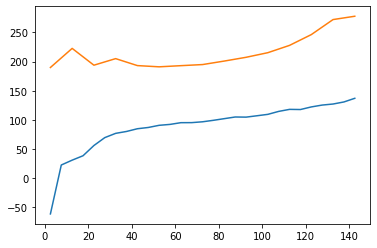

In [389]:
s13, s14, s15, lil23, erk19, erk20, grv19, vas23 = get_shell_bulk_motions()
_, _, _, _, _, _, _, _, d22 = get_bulk_motion_inertial()

plt.plot(d22['r'], d22['phi'])
plt.plot(erk20['r'], erk20['phi'])

N FROM get binned fit medians: 4


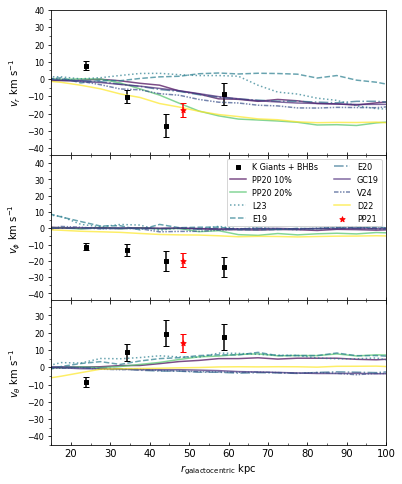

In [399]:
def make_figure_2():
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_bulk_motion_data(ax,"combined", "sgr_20", "k",  "s",ebarc="g",label=r"K Giants + BHBs")
#     make_bulk_motion_sim(ax, live=True)
    make_bulk_motion_inertial(ax,live=True,PP21=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    ax[0].set_ylim(-44,40)
    ax[1].set_ylim(-44,39)
    ax[2].set_ylim(-45,39)
    plt.savefig(savedir +"figure2.pdf",facecolor="white", dpi=500)
    
def make_figure2_4bin():
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_bulk_motion_data(ax,"combined", "sgr_20_4bin", "k",  "s",ebarc="g",label=r"K Giants + BHBs")
#     make_bulk_motion_sim(ax, live=True)
    make_bulk_motion_inertial(ax,live=True,PP21=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    ax[0].set_ylim(-44,40)
    ax[1].set_ylim(-44,39)
    ax[2].set_ylim(-45,39)
    plt.savefig(savedir +"figure2_4bin.pdf",facecolor="white", dpi=500)
    
def make_figure2_4bin_massratio():
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_bulk_motion_data(ax,"combined", "sgr_20_4bin", "k",  "s",ebarc="k",label=r"K Giants + BHBs")
#     make_bulk_motion_sim(ax, live=True)
    make_bulk_motion_inertial_massratio(ax,live=True,PP21=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    ax[0].set_ylim(-44,40)
    ax[1].set_ylim(-44,45)
    ax[2].set_ylim(-45,39)
    plt.savefig(savedir +"figure2_4bin_massratio.pdf",facecolor="white", dpi=500)
    
make_figure2_4bin_massratio()

N FROM get binned fit medians: 5
no separation
[25.         35.         45.         55.         71.80986274]
N FROM get binned fit medians: 5
no separation
[25.         35.         45.         55.         72.25158815]
N FROM get binned fit medians: 5
no separation
[24.41249721 33.99504484 44.12624073 54.9673155  71.71991184]
[-61.23157357  22.65407091  30.98603768  38.53620392  56.06944978
  69.62297323  76.94632255  80.20140629  84.85971142  87.03136323
  90.74031305  92.30056731  95.25587405  95.35370285  96.79961292
  99.34365348 102.18323632 105.01016966 104.77894726 107.12888751
 109.5388173  114.61647556 118.09923    117.81620062 122.28687362
 125.46784298 127.26252982 130.80839521 137.07141913] [ -8.2126716  -47.82154306 -55.13989951 -66.01677598 -68.21547706
 -69.57439271 -69.68908866 -69.78063881 -68.57282402 -69.23795467
 -68.68910286 -69.33953836 -70.52457106 -71.20876306 -72.27152342
 -73.24011255 -74.09288216 -75.20453643 -76.46154737 -77.41272293
 -78.56408108 -79.1809863

<Figure size 432x288 with 0 Axes>

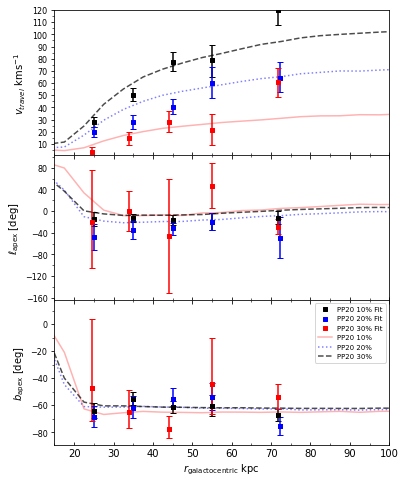

In [16]:
def make_appendix_A1():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"binned", "s15", "k",  "s",ebarc="k",label=r"PP20 10% Fit",plot_sep=False)
    make_apex_data(ax,"binned", "s14", "b",  "s",ebarc="b",label=r"PP20 20% Fit",plot_sep=False)
    make_apex_data(ax,"binned", "s13", "r",  "s",ebarc="r",label=r"PP20 30% Fit",plot_sep=False)

    # make_apex_data(ax,"allsky", "s15", "b",  "s",ebarc="b",label=r"sdss footprint",plot_sep=False)
    ax[0].set_ylim(1,120)
    make_apex_sim_massratio(ax,False, live=False, PP21=False,mockcompare=True)
    # ax[1].set_ylim(0,300)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=7, loc="upper right")
    plt.savefig(savedir +"A1-validation.pdf",facecolor="white", dpi=300)

def make_appendix_A2():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_bulk_motion_data(ax,"binned", "s15", "k",  "s",ebarc="k",label=r"PP20 30% Fit")
    make_bulk_motion_data(ax,"binned", "s14", "b",  "s",ebarc="b",label=r"PP20 20% Fit")
    make_bulk_motion_data(ax,"binned", "s13", "r",  "s",ebarc="r",label=r"PP20 10% Fit")
    
    make_bulk_motion_inertial(ax, live=False,mockcompare=True)
#     make_bulk_motion_sim(ax, live=False,mockcompare=False, PP21=False,reflex_correct=True)

    ax[0].set_ylim(-60,60)
#     ax[2].set_xlim(0,150)
    # make_apex_data(ax,"allsky", "s15", "b",  "s",ebarc="b",label=r"sdss footprint",plot_sep=False)
#     make_bulk_motion_sim(ax,True, live=False, PP21=False,mockcompare=True)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[0].legend(by_label.values(), by_label.keys(),fontsize=7, loc="upper right")
    plt.savefig(savedir +"A2-validation.pdf",facecolor="white", dpi=300)
    ax[0].set_ylim(-59,40)
    ax[1].set_ylim(-49,49)
    ax[2].set_ylim(-50,49)
    
# make_appendix_A2()

make_appendix_A1()


N FROM get binned fit medians: 5
N FROM get binned fit medians: 4
AxesSubplot(0.125,0.628333;0.775x0.251667) [-6.000e-02 -8.200e-01  5.200e-01 -2.100e-01  1.000e-01 -2.000e-02
 -2.260e+00 -5.670e+00 -9.300e+00 -1.403e+01 -1.855e+01 -2.133e+01
 -2.319e+01 -2.373e+01 -2.431e+01 -2.505e+01 -2.662e+01 -2.645e+01
 -2.692e+01 -2.542e+01 -2.450e+01 -2.241e+01 -2.153e+01 -1.888e+01
 -1.742e+01 -1.670e+01 -1.473e+01 -1.471e+01 -1.430e+01 -1.461e+01
 -1.597e+01]
AxesSubplot(0.125,0.376667;0.775x0.251667) [ 0.26  0.67  0.58  0.26 -0.39  0.53 -0.21  0.22 -0.33 -0.13 -2.1  -1.47
 -3.91 -4.34 -3.22 -4.05 -3.39 -3.05 -3.46 -2.61 -2.96 -2.   -1.97 -2.12
 -1.99 -1.75 -1.18 -1.6  -1.51 -1.25 -1.18]
AxesSubplot(0.125,0.125;0.775x0.251667) [ 1.23  0.56 -0.38 -0.38  0.2  -0.21  0.42  1.63  2.8   4.5   6.04  6.48
  7.39  7.73  6.64  6.79  6.75  7.71  6.55  7.17  7.01  6.78  6.22  6.66
  6.2   6.24  5.69  6.21  6.21  5.77  5.95]


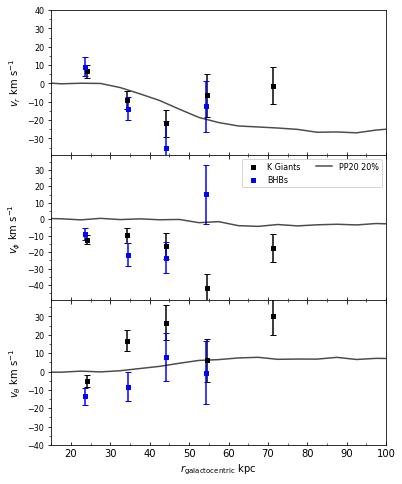

In [21]:
def make_appendix_B1():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"binned", "s14", "k",  "s",ebarc="k",label=r"PMM 20% SDSS footprint Fit",plot_sep=False)
    make_apex_data(ax,"north",  "s14", "b",  "s",ebarc="b",label=r"PMM 20% $b > 0^{\circ}$ Fit",plot_sep=False)
    make_apex_data(ax,"allsky", "s14", "r",  "s",ebarc="r",label=r"PMM 20% all-sky Fit",plot_sep=False)

    # make_apex_data(ax,"allsky", "s15", "b",  "s",ebarc="b",label=r"sdss footprint",plot_sep=False)
    ax[0].set_ylim(1,120)
    make_apex_sim_massratio(ax,False, live=False, PP21=False, choice=1)
    # ax[1].set_ylim(0,300)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right")
    plt.savefig(savedir + "B1-Skyselect.pdf",facecolor="white", dpi=300)

def make_appendix_B2():
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_bulk_motion_data(ax,"binned", "s14", "k",  "s",ebarc="k",label=r"PMM 20% SDSS footprint only")
    make_bulk_motion_data(ax,"north",  "s14", "b",  "s",ebarc="b",label=r"PMM 20% $b > 0^{\circ}$")
    make_bulk_motion_data(ax,"allsky", "s14", "r",  "s",ebarc="r",label=r"PMM 20% all-sky Fit")
    
    # make_apex_data(ax,"allsky", "s15", "b",  "s",ebarc="b",label=r"sdss footprint",plot_sep=False)
    make_bulk_motion_inertial(ax,live=False, PP21=False,choice=1)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right")
    ax[0].set_ylim(-49,40)
    ax[1].set_ylim(-39,39)
    ax[2].set_ylim(-40,39)
    plt.savefig(savedir +"B2-Skyselect.pdf",facecolor="white", dpi=300)
# make_appendix_B1()
# make_appendix_B2()



def make_appendix_C1():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"KG", "sgr_20", "k",  "s",ebarc="k",label=r"K Giants",plot_sep=False)
    make_apex_data(ax,"BHB", "sgr_20", "b",  "s",ebarc="b",label=r"BHBs",plot_sep=False)
    
    
    ax[0].set_ylim(1,100)
    make_apex_sim(ax,False, live=True, PP21=True, choice=0)

    ax[1].set_ylim(110,359)
    ax[2].set_ylim(-90,50)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    plt.savefig(savedir +"C1-BHBvKG.pdf",facecolor="white", dpi=300)
    

def make_appendix_C2():
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_bulk_motion_data(ax,"KG", "sgr_20", "k",  "s",ebarc="k",label=r"K Giants")
    make_bulk_motion_data(ax,"BHB", "sgr_20", "b",  "s",ebarc="b",label=r"BHBs")
    make_bulk_motion_inertial(ax,live=False,PP21=False, choice=1)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    ax[0].set_ylim(-39,40)
    ax[1].set_ylim(-49,39)
    ax[2].set_ylim(-40,39)
    plt.savefig(savedir +"C2-BHBvKG.pdf",facecolor="white", dpi=300)

# make_appendix_C1()
make_appendix_C2()
# make_appendix_B1()
# make_appendix_B2()

In [ ]:
def make_appendix_D1():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_apex_data(ax,"combined", "sgr_20_ol5", "grey",  "s",ebarc="g",label=r"K Giants + BHBs; 5kpc shift",plot_sep=False)
    make_apex_data(ax,"combined", "sgr_20", "k",  "s",ebarc="g",label=r"K Giants + BHBs",plot_sep=False)
    
    
    ax[0].set_ylim(1,100)
    make_apex_sim(ax,False, live=True, PP21=True, choice=0)
    ax[1].set_ylim(110,359)
    ax[2].set_ylim(-90,65)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    plt.savefig(savedir +"D1-OverlapBin.pdf",facecolor="white", dpi=300)
    

def make_appendix_D2():
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_bulk_motion_data(ax,"combined", "sgr_20_ol5", "grey",  "s",ebarc="g",label=r"K Giants + BHBs; 5kpc shift")
    make_bulk_motion_data(ax,"combined", "sgr_20", "k",  "s",ebarc="g",label=r"K Giants + BHBs")
    make_bulk_motion_inertial(ax,live=True,PP21=True, choice=0)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[1].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    ax[0].set_ylim(-39,40)
    ax[1].set_ylim(-39,39)
    ax[2].set_ylim(-40,39)
    plt.savefig(savedir +"D2-OverlapBin.pdf",facecolor="white", dpi=300)
make_appendix_D1()
make_appendix_D2()

In [ ]:
def make_dispersions_data(ax, mock, btype, color, marker,ebarc="g",label=None,plotsim=True):
    M, Eu, Ed = get_binned_fit_medians(mock,btype)
    midpoints, N = get_bin_values(mock,btype)
    #sig_vlos
    ax[0].errorbar(midpoints, M[:,6], yerr = [Ed[:,6],Eu[:,6]], color=ebarc,fmt="none", capsize=3)
    ax[0].scatter(midpoints, M[:,6], c=color, marker=marker,s=20,zorder=100, label=label)
    #vphi
    ax[1].errorbar(midpoints, M[:,7], yerr = [Ed[:,7],Eu[:,7]], color=ebarc,fmt="none", capsize=3)
    ax[1].scatter(midpoints, M[:,7], c=color, marker=marker,s=20,zorder=100, label=label)
    #vtheta
    ax[2].errorbar(midpoints, M[:,8], yerr = [Ed[:,8],Eu[:,8]], color=ebarc,fmt="none", capsize=3)
    ax[2].scatter(midpoints, M[:,8], c=color, marker=marker,s=20,zorder=100, label=label)



    ax[0].yaxis.set_minor_locator(MultipleLocator(5))
    ax[0].yaxis.set_major_locator(MultipleLocator(10))
    ax[0].set_ylabel(r"$\sigma_{los}$ kms$^{-1}$ ")
    ax[0].tick_params(axis="x", which="both", labelbottom=False, direction="in")
    
    ax[1].yaxis.set_minor_locator(MultipleLocator(5))
    ax[1].yaxis.set_major_locator(MultipleLocator(10))
    ax[1].set_ylabel(r"$\sigma_{l}$ kms$^{-1}$ ")
    ax[1].tick_params(axis="x", which="both", labelbottom=False, direction="in",top=True)
    
    ax[2].yaxis.set_minor_locator(MultipleLocator(5))
    ax[2].yaxis.set_major_locator(MultipleLocator(10))
    ax[2].set_ylabel(r"$\sigma_{b}$ kms$^{-1}$ ")
    ax[2].set_xlabel(r"$r_{\rm galactocentric}$ kpc ")
    ax[2].tick_params(axis="x", which="both", direction="in",top=True)

    for i in ax:
        i.tick_params(axis="y", labelsize=8)
        i.set_xlim(15,100)
#         i.set_ylim(-40,40)
        i.xaxis.set_minor_locator(MultipleLocator(5))
        i.xaxis.set_major_locator(MultipleLocator(10))
    return ax

In [ ]:
def make_appendix_E1():
    plt.clf()
    fig,ax = plt.subplots(3, facecolor="white",figsize=(6,8))
    plt.subplots_adjust(hspace=0.0)

    make_dispersions_data(ax,"north", "s14", "k",  "s",ebarc="g",label=r"K Giants + BHBs")
    make_dispersions_data(ax,"binned", "s14", "r",  "s",ebarc="r",label=r"s13 sim")
#     make_apex_data(ax,"combined", "sgr_20", "k",  "s",ebarc="g",label=r"K Giants + BHBs",plot_sep=False)
    
    
#     ax[0].set_ylim(1,60)
#     make_apex_sim(ax,False)
#     ax[1].set_ylim(110,359)
#     ax[2].set_ylim(-90,50)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(
        labels, handles))
    ax[2].legend(by_label.values(), by_label.keys(),fontsize=8, loc="upper right",ncol=2)
    # plt.savefig("plots/031123-postsatfix/s14_s15_sdss_vtravel_l_b.png",facecolor="white", dpi=300)
    
make_appendix_E1()

In [ ]:
def generate_latex_table_with_errors(matrix, eu_matrix, ed_matrix):
    rows, columns = matrix.shape

    # Ensure the number of columns matches the predefined column names
    if columns != 4:
        raise ValueError("Number of columns in the matrix must be 4.")

    column_names = ["20-30", "30-40", "40-50", "50+"]
    row_names = [r"$ell_{\text{apex}}$", r"$b_{\text{apex}}$", r"$v_{\text{travel}}", 
                 r"$<v_{r}>$", r"$<v_{\phi}>$", r"$<v_{\theta}>$", r"$\sigma_{los}$", r"$\sigma_l$", r"$\sigma_b$"]

    # Ensure the number of rows matches the predefined row names
    if rows != len(row_names):
        raise ValueError("Number of rows in the matrix must match the predefined row names.")

    table_header = " & ".join(["parameters"] + column_names) + " \\\\ \\hline"

    # Populate the table with values and errors from the matrices
    table_body = ""
    plus = "+"
    minus= "-"
    for i in range(rows):
        row_values = f"{row_names[i]} & "
        for j in range(columns):
            value = int(matrix[i, j])
            upper_error = int(eu_matrix[i, j])
            lower_error = int(ed_matrix[i, j])

            # Format the value with upper and lower errors
            formatted_value = f"{value}$^{{+{upper_error}}}_{{-{lower_error}}}$"
            row_values += f"{formatted_value} & "
        
        # Remove the trailing "& " and add the row-ending command
        row_values = row_values[:-2] + " \\\\ \\hline"
        print(row_values)
        table_body += row_values + "\n"

    latex_table = f"\\begin{{tabular}}{{|c|c|c|c|c|c|}}\n{table_header}\n{table_body}\\end{{tabular}}"

    with open("output_table.tex", "w") as file:
        file.write(latex_table)
M, Eu, Ed = get_binned_fit_medians("combined", "sgr_20_4bin")  # Replace this with your actual matrix

generate_latex_table_with_errors(np.round(M.T,decimals=0),np.rint(Eu.T),np.rint(Ed.T))
print(M.T[:3,-1])

In [ ]:
print(Eu.T[:3,-1])

In [ ]:
print(Ed.T[:3,-1])